In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [84]:
table = pd.read_table('../drug-discovery/1663769555_8559356_train.txt', names=['binding','sequence'])

In [85]:
table.binding.value_counts()

0    722
1     78
Name: binding, dtype: int64

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed


In [87]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form_with_vocab(data_frame, vocab):
    count_vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [88]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [155]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size=.75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.70)

In [156]:
active_train_df = pd.DataFrame(active_train)
active_test_df = pd.DataFrame(active_test)
active_binding_train_df = pd.DataFrame(active_binding_train)
active_binding_test_df = pd.DataFrame(active_binding_test)

active_train_df['binding'] = active_binding_train_df['binding']
active_test_df['binding'] = active_binding_test_df['binding']

In [157]:
not_active_train_df = pd.DataFrame(not_active_train)
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_train_df = pd.DataFrame(not_active_binding_train)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)

not_active_train_df['binding'] = not_active_binding_train_df['binding']
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [158]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    505
1     58
Name: binding, dtype: int64
0    217
1     20
Name: binding, dtype: int64


In [159]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)
x_test_sampled, y_test_sampled = sampler.fit_resample(np.array(test_df.sequence).reshape(-1,1),test_df.binding)

In [160]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(x_test_sampled,columns=['sequence'])
# final_test_set['sequence'] = x_test_sampled
final_test_set['binding'] = y_test_sampled
# test_df['binding']
print(final_test_set.binding.value_counts())

1    505
0    505
Name: binding, dtype: int64
1    217
0    217
Name: binding, dtype: int64


In [161]:
vectorizer_global, training_features = return_binary_vectorized_form(final_train_set.sequence)
k_best_feature = select_k_best_features(training_features, final_train_set.binding, .90, vectorizer_global.get_feature_names_out())
vectorizer_k_best, training_split = return_binary_vectorized_form_with_vocab(final_train_set.sequence,k_best_feature)
test_split = vectorizer_k_best.transform(final_test_set.sequence).toarray()

In [162]:
print(training_split.shape)
print(test_split.shape)

(1010, 73099)
(434, 73099)


In [163]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
print(train_result.shape)
print(test_result.shape)

(1010,)
(434,)


In [164]:
test_result.sum()

217

In [165]:
train_result.sum()

505

In [166]:
# pd.concat(training_split,test_split)

In [167]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import  f1_score
dt_clf = DecisionTreeClassifier(criterion='gini')
path = dt_clf.cost_complexity_pruning_path(training_split, train_result)
alphas, impurity = path.ccp_alphas, path.impurities
print(len(alphas))
alphas = alphas[:-1]
print(len(alphas))
clfs = []
for alpha in alphas:
    d_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    d_tree.fit(training_split, train_result)
    clfs.append(d_tree)

15
14


5

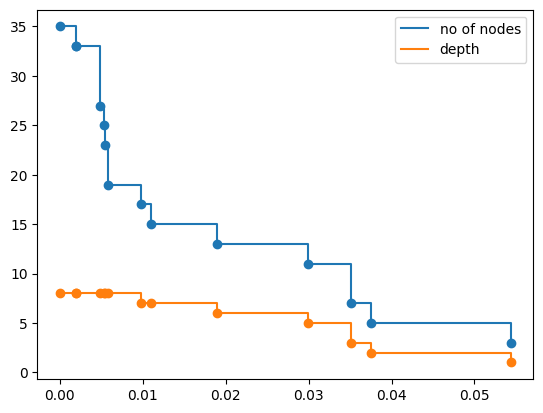

In [168]:

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(alphas,node_counts)
plt.scatter(alphas,depth)
plt.plot(alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
clfs[-4].tree_.max_depth

0.5605095541401275 0
0.5605095541401275 1
0.5605095541401275 2
0.617737003058104 3
0.617737003058104 4
0.617737003058104 5
0.6529411764705882 6
0.6529411764705882 7
0.6434782608695652 8
0.6434782608695652 9
0.6548672566371683 10
0.6055045871559633 11
0.6130030959752322 12
0.6149068322981366 13


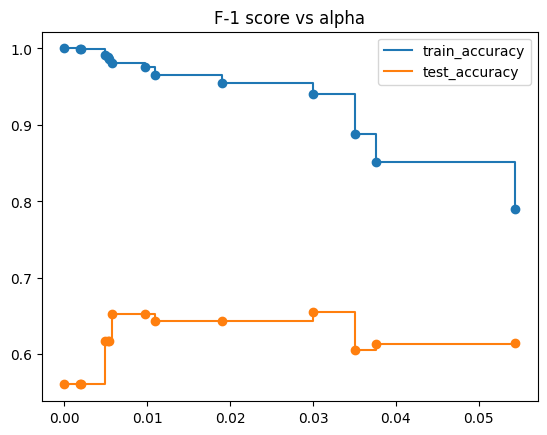

0


array([0.        , 0.00190404, 0.00197432, 0.00489225, 0.00532605,
       0.0054314 , 0.00575178, 0.00979764, 0.01100425, 0.0189942 ,
       0.02994859, 0.03510202, 0.0375855 , 0.05439016])

In [179]:
train_acc = []
test_acc = []
cur_max = 0
index = 0
p = -1
for c in clfs:
    y_train_pred = c.predict(training_split)
    y_test_pred = c.predict(test_split)
    train_acc.append(f1_score(train_result,y_train_pred))
    test_acc.append(f1_score(test_result,y_test_pred))
    p += 1
    print(test_acc[-1], p)

plt.scatter(alphas,train_acc)
plt.scatter(alphas,test_acc)
plt.plot(alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('F-1 score vs alpha')
plt.show()
print(cur_max)
# print(alpha_max)
alphas

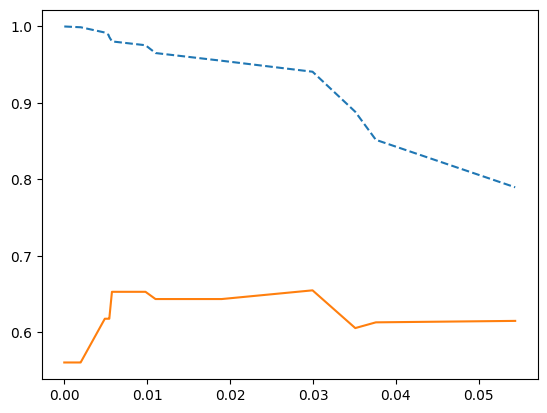

In [171]:
plt.plot(alphas,train_acc,'--')
plt.plot(alphas,test_acc,'-')
plt.show()

In [172]:
table_test = pd.read_table('../drug-discovery/1663769555_8653905_test.txt', names=['sequence'])

In [173]:
unlabeled_test_sequence = vectorizer_k_best.transform(table_test.sequence).toarray()
# unlabeled_test_sequence = pca.transform(unlabeled_test_sequence)

In [174]:
unlabeled_test_sequence.shape

(350, 73099)

In [175]:
training_features = vectorizer_k_best.transform(table.sequence)
y = DecisionTreeClassifier(criterion='gini',ccp_alpha=0.025327)

In [176]:
y.fit(training_features, table.binding)


DecisionTreeClassifier(ccp_alpha=0.025327)

In [178]:
from sklearn.metrics import f1_score
k = y.predict(test_split)
f1_score(test_result,k)

0.6149068322981366

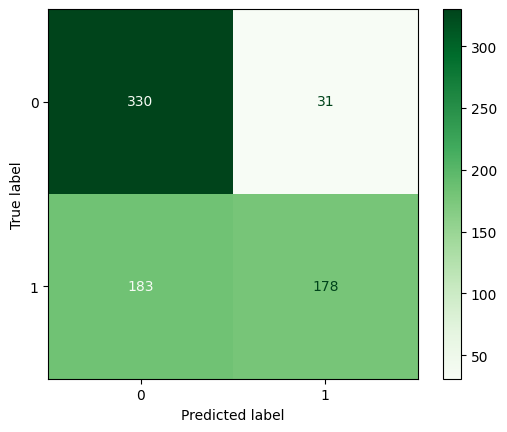

In [135]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_result,k,cmap='Greens')

In [136]:
t = y.predict(unlabeled_test_sequence)

In [137]:
t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [138]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], t))
outfile.close()